In [2]:
import pytesseract
import os
import requests
from PIL import Image
from pathlib import Path

In [3]:
from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.models import CustomJS, TextInput

In [4]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"

In [6]:
# 🚀 get the image to process in Colab
image_path = r"assets\images\grippe.jpeg"
img = Image.open(image_path)

In [5]:
ocr_output = pytesseract.image_to_string(img, lang='deu_latf') # Wir verwenden das Fraktur-OCR-Modell

In [6]:
ocr_output

'Zie Grippe wüfel weiter\n\nZunahme der ſchweren Fälle in Berlin.\n\nDie Zahl der Grippefälle iſt in den letzten\nbeider Tagen auch in Groß-Berlin noH\nerfblih zefitiegen. Die Worenhäuſer und ſon-\nHaen aroßen GerſHäfte, die Krirgs- und die pri«\nn Betriebe lagen, daß übermäig viele An«\n\n: fich 5cben kren? melden miüen,-und an:\n; ew Loſt und 5ei der Straßenbahn iſt der\nſoz der Grippekranken bedeuten) g&\n'

In [7]:
output_notebook()

capture_ground_truth = TextInput(value="""Die Grippe wütet weiter. Zunahme der schweren Fälle in Berlin. Die Zahl der Grippefälle ist in den letzten Tagen auch in Groß-Berlin noch erheblich gestiegen. Die Warenhäuser und sonstigen großen Geschäfte, die Kriegs- und die privaten Betriebe klagen, daß übermäßig viele Angestellte sich haben krank melden müssen und auch bei der Post und bei der Straßenbahn ist der Prozentsatz der Grippekranken deutlich gestiegen.""", 
                                 title="Please insert corrected string: ") 

ground_truth = capture_ground_truth.value.strip()

rewrite_var_after_input = CustomJS(args=dict(text_input=capture_ground_truth), code="""
    var word = text_input.value.trim();
    console.log('Input value:', word);
    function sendToPython(){
    var kernel = IPython.notebook.kernel;
    kernel.execute("ground_truth = '" + word + "'");
    }
    sendToPython();
""")



capture_ground_truth.js_on_change('value', rewrite_var_after_input)

Loading BokehJS ...

In [8]:
# Layout and display
layout = column(capture_ground_truth)

show(layout)

In [29]:
print(ground_truth)

Die Grippe wütet weiter. Zunahme der schweren Fälle in Berlin. Die Zahl der Grippefälle ist in den letzten Tagen auch in Groß-Berlin noch erheblich gestiegen. Die Warenhäuser und sonstigen großen Geschäfte, die Kriegs- und die privaten Betriebe klagen, daß übermäßig viele Angestellte sich haben krank melden müssen und auch bei der Post und bei der Straßenbahn ist der Prozentsatz der Grippekranken deutlich gestiegen.


In [30]:
from auxiliary.measure_ocr_quality import measure_ocr_quality

### Evaluating OCR Quality: A "Ground Truth" Comparison

To understand the accuracy of our digital text, we first need to see what kind of errors the OCR (Optical Character Recognition) process makes. We took a small sample of the newspaper and manually transcribed it perfectly—this is our **"Ground Truth"**.

We then compared it to the **Raw OCR Output**.

| Type | Text Snippet Example |
| :--- | :--- |
| **Ground Truth** | "Die Grippe wütet weiter. Zunahme der schweren Fälle in Berlin." |
| **Raw OCR Output** | "Zie Grippe wüfel weiter Zunahme der ſchweren Fälle in Berlin." |

As you can see, the Raw OCR output contains several typical errors:
* Character confusion (**Z**ie vs. **D**ie)
* Inserted artifacts (**5**ei vs. **b**ei)
* Historical Character Normalization (i**ſ**t vs. i**s**t)
* Word splitting (**prie** n vs. **privaten**)

To measure the *scale* of this problem across our entire dataset, we calculated three standard metrics: Precision, Recall, and the F1-Measure.

In [31]:
precision, recall, f_score = measure_ocr_quality(ocr_output, ground_truth)

In [32]:
print(f'Precision: {round(precision, 4)}\nRecall: {round(recall, 4)}\nF1-score: {round(f_score, 4)}')

Precision: 0.79
Recall: 0.8317
F1-score: 0.8103


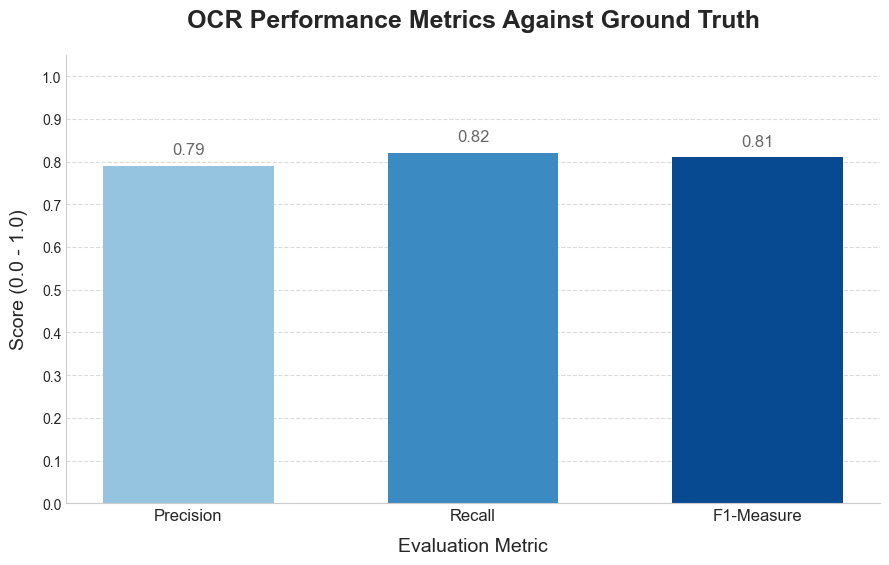

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# --- Your Calculated Data ---
precision = precision
recall = recall
f1_measure = f_score

# Define the labels and the scores
metrics = ['Precision', 'Recall', 'F1-Measure']
scores = [precision, recall, f1_measure]

# --- Customizing Plot Styles ---
plt.style.use('seaborn-v0_8-whitegrid') # A clean, professional style (or 'ggplot', 'fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6)) # Slightly larger for better readability

# Define a color palette (you can choose others like 'viridis', 'plasma', or custom hex codes)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(scores))) # Gradient blue tones

# Create the bar plot
bars = ax.bar(metrics, scores, color=colors, width=0.6) # Adjust bar width

# --- Enhance Labels and Title ---
ax.set_title('OCR Performance Metrics Against Ground Truth', 
             fontsize=18, 
             fontweight='bold', 
             pad=20) # Add padding to title
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=14, labelpad=10)
ax.set_xlabel('Evaluation Metric', fontsize=14, labelpad=10)

# --- Set Y-Axis Limit and Ticks ---
ax.set_ylim(0, 1.05) # Extend slightly above 1.0 to give space for labels
ax.set_yticks(np.arange(0, 1.1, 0.1)) # Set ticks every 0.1

# --- Add Grid Lines ---
ax.yaxis.grid(True, linestyle='--', alpha=0.7) # Only horizontal grid lines
ax.xaxis.grid(False) # Remove vertical grid lines if desired

# --- Add Data Labels on Top of Bars ---
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, # Position
            f'{yval:.2f}', # Format to two decimal places
            ha='center', va='bottom', 
            fontsize=12, 
            color='dimgray')

# --- Customize Spines (Borders) ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# --- Improve Tick Parameters ---
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=10)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout, leaving space for title
plt.show()